In [26]:
########################################################### IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary, set_trainable
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import sys
sys.path.append('../src')
from data_preparation import get_birth_data, plot_data, separate_data

from gpflow.ci_utils import ci_niter, ci_range

tf.keras.backend.set_floatx("float64")


In [27]:
data = get_birth_data()
x, y = separate_data(data, normalised=True)
#x_w, y_w = separate_data(data, normalised=True, weekdays=True)

x = x.numpy()
y = y.numpy()

def get_xticks(data):
    idss = []; yrs = []
    yr = 1969
    for i in range(20):
        df = data.loc[data.year == yr+i]
        yrs.append(yr+i)
        idss.append(df.index[0])
    return idss, yrs

pos, labels = get_xticks(data)

In [32]:
def plot_distribution(X, Y, loc, scale, pos, labels):
    plt.figure(figsize=(15, 5))
    x = X.squeeze()

    lb = (loc - 1.96 * scale).squeeze()
    ub = (loc + 1.96 * scale).squeeze()

    plt.fill_between(x, lb, ub, color="C0", alpha=0.4)
    #plt.plot(x, lb, color="C0")
    #plt.plot(x, ub, color="C0")
    plt.plot(X, Y, '.', color="black", alpha=0.5, markersize=3)
    plt.plot(X, loc, color="C0")

    plt.title('EXP(GP)  --- Amazing!!!')
    plt.xticks(pos, labels)
    plt.xlabel('Date')
    plt.ylabel('Births')
    
    plt.show()
    plt.close()

In [29]:
from typing import Any, Optional, Type

import tensorflow as tf
import tensorflow_probability as tfp

from gpflow.utilities import positive
from gpflow.base import TensorType
from gpflow.likelihoods.multilatent import MultiLatentTFPConditional

class CustomTFPConditional(MultiLatentTFPConditional):
    """
    Heteroskedastic Likelihood where the conditional distribution
    is given by a TensorFlow Probability Distribution.
    The `loc` and `scale` of the distribution are given by a
    two-dimensional multi-output GP.
    """

    def __init__(
        self,
        distribution_class: Type[tfp.distributions.Distribution] = tfp.distributions.Normal,
        loc_transform: Optional[tfp.bijectors.Bijector] = None,
        **kwargs: Any,
    ) -> None:
        """
        :param distribution_class: distribution class parameterized by `loc` and `scale`
            as first and second argument, respectively.
        :param scale_transform: callable/bijector applied to the latent
            function modelling the scale to ensure its positivity.
            Typically, `tf.exp` or `tf.softplus`, but can be any function f: R -> R^+. Defaults to exp if not explicitly specified.
        """

        if loc_transform is None:
            loc_transform = tfp.bijectors.Identity()
        self.loc_transform = loc_transform

        def conditional_distribution(Fs: TensorType) -> tfp.distributions.Distribution:
            tf.debugging.assert_equal(tf.shape(Fs)[-1], 2)
            scale_transform = positive(base="exp")
            scale = scale_transform(Fs[..., 1:])
            loc = Fs[..., :1] + 0.3 * self.loc_transform(Fs[..., :1])
            return distribution_class(loc, scale)

        super().__init__(
            latent_dim=2,
            conditional_distribution=conditional_distribution,
            **kwargs,
        )

In [30]:
likelihood = CustomTFPConditional(
    distribution_class = tfp.distributions.Normal,  # Gaussian Likelihood
    loc_transform = tfp.bijectors.Exp(),  # Exponential Transform
)

print(f"Likelihood's expected latent_dim: {likelihood.latent_dim}")

#### jitter
kernel = gpflow.kernels.SeparateIndependent(
    [
        gpflow.kernels.RBF(),  #gpflow.kernels.Periodic(gpflow.kernels.RBF()) gpflow.kernels.Matern52() + 
        gpflow.kernels.RBF(),  
    ]
)


M = 2000  # Number of inducing variables for each f_i

# Initial inducing points position Z
Z = np.linspace(x.min(), x.max(), M)[:, None]  # Z must be of shape [M, 1]

inducing_variable = gpflow.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpflow.inducing_variables.InducingPoints(Z),  
        gpflow.inducing_variables.InducingPoints(Z),  
    ]
)

model = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=likelihood.latent_dim,
)

# model = gpflow.models.VGP(
#     data=(x.numpy(),y.numpy()),
#     kernel=kernel,
#     likelihood=likelihood,
#     num_latent_gps=likelihood.latent_dim,
# )

model

Likelihood's expected latent_dim: 2


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(2000, 1)",float64,[[1.00000000e+00...
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(2000, 1)",float64,[[1.00000000e+00...
SVGP.q_mu,Parameter,Identity,,True,"(2000, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 2000, 2000)",float64,"[[[1., 0., 0...."


Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19
Epoch  20
Epoch 20 - Loss:  16637.1630


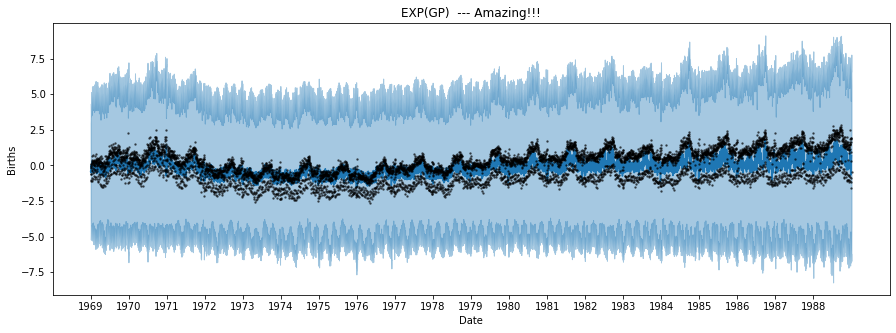

Epoch  21
Epoch  22
Epoch  23
Epoch  24
Epoch  25
Epoch  26
Epoch  27
Epoch  28
Epoch  29
Epoch  30
Epoch  31
Epoch  32
Epoch  33
Epoch  34
Epoch  35
Epoch  36
Epoch  37
Epoch  38
Epoch  39
Epoch  40
Epoch 40 - Loss:  14804.0299


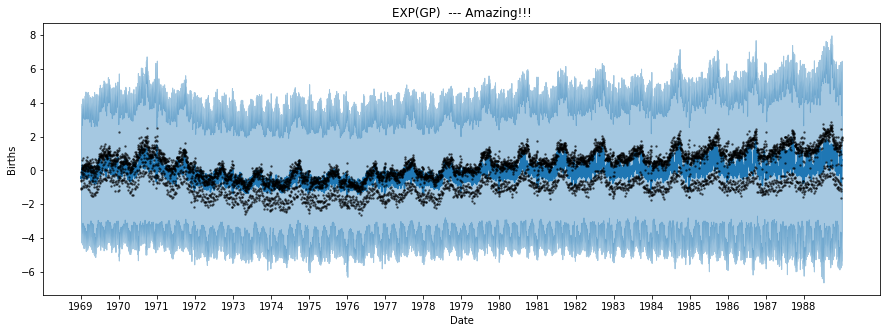

Epoch  41
Epoch  42
Epoch  43
Epoch  44
Epoch  45
Epoch  46
Epoch  47
Epoch  48
Epoch  49
Epoch  50
Epoch  51
Epoch  52
Epoch  53
Epoch  54
Epoch  55
Epoch  56
Epoch  57
Epoch  58
Epoch  59
Epoch  60
Epoch 60 - Loss:  13702.5879


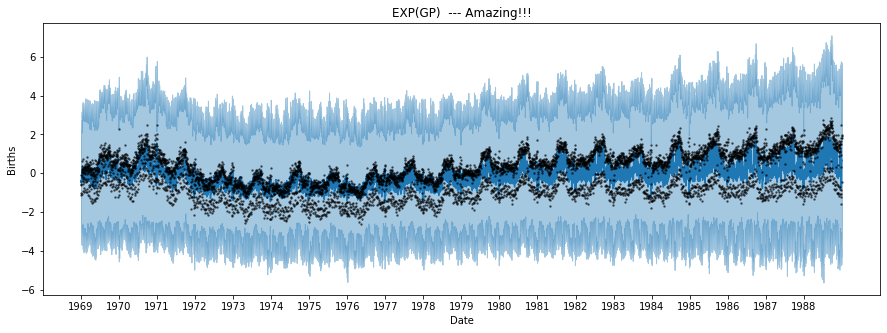

Epoch  61
Epoch  62


KeyboardInterrupt: 

In [33]:
data = (x, y)
loss_fn = model.training_loss_closure(data) 

gpflow.utilities.set_trainable(model.q_mu, False)
gpflow.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)

adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

epochs = 100
log_freq = 20

for epoch in range(1, epochs + 1):
    print('Epoch ', epoch)
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        Ymean, Yvar = model.predict_y(x)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(x, y, Ymean, Ystd, pos, labels)

model